# Intro to Deep Learning Systems: Lab 3

In [6]:
import torch, torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as transF
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
# from pytorch_cifar import resnet

## Adaptive Learning Rate Methods, CIFAR-10
### Q1.1
$g_t=\nabla_{\theta_t}J(\theta_t)$
#### Adagrad
$\theta_{t+1,i}=\theta_{t,1}-\frac{\eta}{\sqrt{G_{t,ii}+\epsilon}}.g_{t,i}$

$G_{t,i}\in\mathbf{R}$ here is a diagonal matrix where each diagonal element i,i is the sum of the squares of the gradients w.r.t $\theta_i$ up to time step $t$ while $\epsilon$ is a smoothing term that avoids division by zero.

#### RMSProp
$E[g^2]_t=0.9E[g^2]_{t-1}+0.1g^2_t$

$\theta_{t+1}=\theta_t-\frac{\eta}{\sqrt{E[g^2]_t+\epsilon}}.g_t$

#### RMSProp + Nesterov
$m_t=\gamma m_{t-1}+\eta g_t$

$\theta_{t+1}=\theta_t-(\gamma m_t+\eta g_t)$

#### Adadelta
$\Delta \theta_t = -\frac{RMS[\Delta \theta]_{t-1}}{RMS[g]_t}g_t$

$\theta_{t+1}=\theta_t+\Delta \theta_t$

#### Adam
$\theta_{t+1}=\theta_t-\frac{\eta}{\sqrt{\hat{v_t}+\epsilon}}\hat{m}_t$ 

#### Load Data

In [27]:
normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
batch_size = 256

trainloader = torch.utils.data.DataLoader(
        torchvision.datasets.CIFAR10(root='./data', train=True, transform=transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, 4),
            transforms.ToTensor(),
            normalize,
        ]), download=True),
        batch_size=batch_size, shuffle=True,
        num_workers=0, pin_memory=True)

valloader = torch.utils.data.DataLoader(
        torchvision.datasets.CIFAR10(root='./data', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ]), download=True),
        batch_size=batch_size, shuffle=True,
        num_workers=0, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


#### Model

In [23]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3072, 1000)
        self.fc2 = nn.Linear(1000, 1000)
        self.fc3 = nn.Linear(1000, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        
        output = F.log_softmax(x, dim=1)
        return output

### Q1.2
#### Training

In [32]:
def get_accuracy(val_loader, model):
    """
    Run evaluation
    """
    correct = 0
    total = 0
    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        for i, (inp, target) in enumerate(val_loader):
            target = target.cuda()
            input_var = inp.cuda()
            target_var = target.cuda()

            # compute output
            output = model(input_var)
            _, prediction = torch.max(output.data, 1)
            
            correct += (prediction == target).sum().item()
            total += target.size(0)

    return (100 * correct) // total


def train_loss(train_loader, model, criterion, optimizer, device, epoch):
    """
        Run one train epoch
    """
    print_freq = 50
    l = len(train_loader)
    
    # switch to train mode
    model.train()
    
    for i, (inputs, target) in enumerate(train_loader):
        target = target.to(device)
        input_var = inputs.to(device)

        # compute output
        output = model(input_var)
        loss = criterion(output, target)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        
        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'.format(epoch, i, l))
        
    return loss.item()

In [5]:
from torch.optim import Adagrad, RMSprop, Adadelta, Adam
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

n_epochs, learning_rate, reg = 200, 1e-3, 1e-4
def RMSNest(*args, **kwargs):
    return RMSprop(*args, **kwargs)

RMSNest.__name__ = "RMSProp+Nesterov"

optim_t = [Adagrad, RMSprop, RMSNest, Adadelta, Adam]

metrics = []
for optim in optim_t:
    print(f"Training using {optim.__name__} optimzer")
    model = Net()
    model = model.to(device)
    
    if optim == RMSNest:
        optimizer = optim(model.parameters(), lr=learning_rate, weight_decay=reg, momentum=0.8)
    else:
        optimizer = optim(model.parameters(), lr=learning_rate, weight_decay=reg)
    
    lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 60, 80, 100, 120, 140, 160, 180])
    criterion = nn.CrossEntropyLoss().to(device)
    
    losses = []
    for epoch in range(n_epochs):
        losses.append(train_loss(trainloader, model, criterion, optimizer, device, epoch))
        lr_scheduler.step()
        
    accuracy = get_accuracy(valloader, model)
    
    metrics.append((losses, accuracy))

Training using Adagrad optimzer
Epoch: [0][0/98]	
Epoch: [0][50/98]	
Epoch: [1][0/98]	
Epoch: [1][50/98]	
Epoch: [2][0/98]	
Epoch: [2][50/98]	
Epoch: [3][0/98]	
Epoch: [3][50/98]	
Epoch: [4][0/98]	
Epoch: [4][50/98]	
Epoch: [5][0/98]	
Epoch: [5][50/98]	
Epoch: [6][0/98]	
Epoch: [6][50/98]	
Epoch: [7][0/98]	
Epoch: [7][50/98]	
Epoch: [8][0/98]	
Epoch: [8][50/98]	
Epoch: [9][0/98]	
Epoch: [9][50/98]	
Epoch: [10][0/98]	
Epoch: [10][50/98]	
Epoch: [11][0/98]	
Epoch: [11][50/98]	
Epoch: [12][0/98]	
Epoch: [12][50/98]	
Epoch: [13][0/98]	
Epoch: [13][50/98]	
Epoch: [14][0/98]	
Epoch: [14][50/98]	
Epoch: [15][0/98]	
Epoch: [15][50/98]	
Epoch: [16][0/98]	
Epoch: [16][50/98]	
Epoch: [17][0/98]	
Epoch: [17][50/98]	
Epoch: [18][0/98]	
Epoch: [18][50/98]	
Epoch: [19][0/98]	
Epoch: [19][50/98]	
Epoch: [20][0/98]	
Epoch: [20][50/98]	
Epoch: [21][0/98]	
Epoch: [21][50/98]	
Epoch: [22][0/98]	
Epoch: [22][50/98]	
Epoch: [23][0/98]	
Epoch: [23][50/98]	
Epoch: [24][0/98]	
Epoch: [24][50/98]	
Epoch: [25][0

Epoch: [4][50/98]	
Epoch: [5][0/98]	
Epoch: [5][50/98]	
Epoch: [6][0/98]	
Epoch: [6][50/98]	
Epoch: [7][0/98]	
Epoch: [7][50/98]	
Epoch: [8][0/98]	
Epoch: [8][50/98]	
Epoch: [9][0/98]	
Epoch: [9][50/98]	
Epoch: [10][0/98]	
Epoch: [10][50/98]	
Epoch: [11][0/98]	
Epoch: [11][50/98]	
Epoch: [12][0/98]	
Epoch: [12][50/98]	
Epoch: [13][0/98]	
Epoch: [13][50/98]	
Epoch: [14][0/98]	
Epoch: [14][50/98]	
Epoch: [15][0/98]	
Epoch: [15][50/98]	
Epoch: [16][0/98]	
Epoch: [16][50/98]	
Epoch: [17][0/98]	
Epoch: [17][50/98]	
Epoch: [18][0/98]	
Epoch: [18][50/98]	
Epoch: [19][0/98]	
Epoch: [19][50/98]	
Epoch: [20][0/98]	
Epoch: [20][50/98]	
Epoch: [21][0/98]	
Epoch: [21][50/98]	
Epoch: [22][0/98]	
Epoch: [22][50/98]	
Epoch: [23][0/98]	
Epoch: [23][50/98]	
Epoch: [24][0/98]	
Epoch: [24][50/98]	
Epoch: [25][0/98]	
Epoch: [25][50/98]	
Epoch: [26][0/98]	
Epoch: [26][50/98]	
Epoch: [27][0/98]	
Epoch: [27][50/98]	
Epoch: [28][0/98]	
Epoch: [28][50/98]	
Epoch: [29][0/98]	
Epoch: [29][50/98]	
Epoch: [30][0/98

Epoch: [9][50/98]	
Epoch: [10][0/98]	
Epoch: [10][50/98]	
Epoch: [11][0/98]	
Epoch: [11][50/98]	
Epoch: [12][0/98]	
Epoch: [12][50/98]	
Epoch: [13][0/98]	
Epoch: [13][50/98]	
Epoch: [14][0/98]	
Epoch: [14][50/98]	
Epoch: [15][0/98]	
Epoch: [15][50/98]	
Epoch: [16][0/98]	
Epoch: [16][50/98]	
Epoch: [17][0/98]	
Epoch: [17][50/98]	
Epoch: [18][0/98]	
Epoch: [18][50/98]	
Epoch: [19][0/98]	
Epoch: [19][50/98]	
Epoch: [20][0/98]	
Epoch: [20][50/98]	
Epoch: [21][0/98]	
Epoch: [21][50/98]	
Epoch: [22][0/98]	
Epoch: [22][50/98]	
Epoch: [23][0/98]	
Epoch: [23][50/98]	
Epoch: [24][0/98]	
Epoch: [24][50/98]	
Epoch: [25][0/98]	
Epoch: [25][50/98]	
Epoch: [26][0/98]	
Epoch: [26][50/98]	
Epoch: [27][0/98]	
Epoch: [27][50/98]	
Epoch: [28][0/98]	
Epoch: [28][50/98]	
Epoch: [29][0/98]	
Epoch: [29][50/98]	
Epoch: [30][0/98]	
Epoch: [30][50/98]	
Epoch: [31][0/98]	
Epoch: [31][50/98]	
Epoch: [32][0/98]	
Epoch: [32][50/98]	
Epoch: [33][0/98]	
Epoch: [33][50/98]	
Epoch: [34][0/98]	
Epoch: [34][50/98]	
Epoch:

Epoch: [14][50/98]	
Epoch: [15][0/98]	
Epoch: [15][50/98]	
Epoch: [16][0/98]	
Epoch: [16][50/98]	
Epoch: [17][0/98]	
Epoch: [17][50/98]	
Epoch: [18][0/98]	
Epoch: [18][50/98]	
Epoch: [19][0/98]	
Epoch: [19][50/98]	
Epoch: [20][0/98]	
Epoch: [20][50/98]	
Epoch: [21][0/98]	
Epoch: [21][50/98]	
Epoch: [22][0/98]	
Epoch: [22][50/98]	
Epoch: [23][0/98]	
Epoch: [23][50/98]	
Epoch: [24][0/98]	
Epoch: [24][50/98]	
Epoch: [25][0/98]	
Epoch: [25][50/98]	
Epoch: [26][0/98]	
Epoch: [26][50/98]	
Epoch: [27][0/98]	
Epoch: [27][50/98]	
Epoch: [28][0/98]	
Epoch: [28][50/98]	
Epoch: [29][0/98]	
Epoch: [29][50/98]	
Epoch: [30][0/98]	
Epoch: [30][50/98]	
Epoch: [31][0/98]	
Epoch: [31][50/98]	
Epoch: [32][0/98]	
Epoch: [32][50/98]	
Epoch: [33][0/98]	
Epoch: [33][50/98]	
Epoch: [34][0/98]	
Epoch: [34][50/98]	
Epoch: [35][0/98]	
Epoch: [35][50/98]	
Epoch: [36][0/98]	
Epoch: [36][50/98]	
Epoch: [37][0/98]	
Epoch: [37][50/98]	
Epoch: [38][0/98]	
Epoch: [38][50/98]	
Epoch: [39][0/98]	
Epoch: [39][50/98]	
Epoch

Epoch: [19][50/98]	
Epoch: [20][0/98]	
Epoch: [20][50/98]	
Epoch: [21][0/98]	
Epoch: [21][50/98]	
Epoch: [22][0/98]	
Epoch: [22][50/98]	
Epoch: [23][0/98]	
Epoch: [23][50/98]	
Epoch: [24][0/98]	
Epoch: [24][50/98]	
Epoch: [25][0/98]	
Epoch: [25][50/98]	
Epoch: [26][0/98]	
Epoch: [26][50/98]	
Epoch: [27][0/98]	
Epoch: [27][50/98]	
Epoch: [28][0/98]	
Epoch: [28][50/98]	
Epoch: [29][0/98]	
Epoch: [29][50/98]	
Epoch: [30][0/98]	
Epoch: [30][50/98]	
Epoch: [31][0/98]	
Epoch: [31][50/98]	
Epoch: [32][0/98]	
Epoch: [32][50/98]	
Epoch: [33][0/98]	
Epoch: [33][50/98]	
Epoch: [34][0/98]	
Epoch: [34][50/98]	
Epoch: [35][0/98]	
Epoch: [35][50/98]	
Epoch: [36][0/98]	
Epoch: [36][50/98]	
Epoch: [37][0/98]	
Epoch: [37][50/98]	
Epoch: [38][0/98]	
Epoch: [38][50/98]	
Epoch: [39][0/98]	
Epoch: [39][50/98]	
Epoch: [40][0/98]	
Epoch: [40][50/98]	
Epoch: [41][0/98]	
Epoch: [41][50/98]	
Epoch: [42][0/98]	
Epoch: [42][50/98]	
Epoch: [43][0/98]	
Epoch: [43][50/98]	
Epoch: [44][0/98]	
Epoch: [44][50/98]	
Epoch

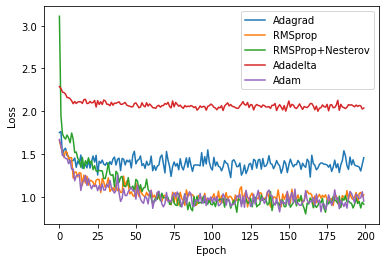

In [10]:
for i, losses in enumerate(metrics):
#     if optim_t[i].__name__ == "RMSProp+Nesterov":
#         continue
    plt.plot(range(n_epochs), losses[0], label=optim_t[i].__name__)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.show()

In [17]:
for i, metric in enumerate(metrics):
    print(f"{metric["optimizer"]}: Final Loss: {metric["losses"][-1]}, Final Accuracy: {metric["accuracy"]}")

Adagrad: Final Loss: 1.4563932418823242, Final Accuracy: 48
RMSprop: Final Loss: 1.0217969417572021, Final Accuracy: 55
RMSProp+Nesterov: Final Loss: 0.9130889177322388, Final Accuracy: 57
Adadelta: Final Loss: 2.0367579460144043, Final Accuracy: 27
Adam: Final Loss: 0.948557436466217, Final Accuracy: 56


As shown above, the **RMSProp+Nesterov** optimizer performs the best.

### Q1.3
#### Model

In [16]:
class Net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3072, 1000)
        self.fc2 = nn.Linear(1000, 1000)
        self.fc3 = nn.Linear(1000, 10)
        self.dropout1 = nn.Dropout2d(0.2)
        self.dropout2 = nn.Dropout2d(0.5)
        self.dropout3 = nn.Dropout2d(0.5)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.dropout1(x)
        x = self.fc1(x)
        x = self.dropout2(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.dropout3(x)
        x = F.relu(x)
        x = self.fc3(x)
        
        output = F.log_softmax(x, dim=1)
        return output

In [26]:
from torch.optim import Adagrad, RMSprop, Adadelta, Adam
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

n_epochs, learning_rate, reg = 200, 1e-3, 1e-4
def RMSNest(*args, **kwargs):
    return RMSprop(*args, **kwargs)

RMSNest.__name__ = "RMSProp+Nesterov"

optim_t = [Adagrad, RMSprop, RMSNest, Adadelta, Adam]

metrics = []
for optim in optim_t:
    print(f"Training using {optim.__name__} optimzer")
    model = Net2()
    model = model.to(device)
    
    if optim == RMSNest:
        optimizer = optim(model.parameters(), lr=learning_rate, weight_decay=reg, momentum=0.8)
    else:
        optimizer = optim(model.parameters(), lr=learning_rate, weight_decay=reg)
    
    lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 60, 80, 100, 120, 140, 160, 180])
    criterion = nn.CrossEntropyLoss().to(device)
    
    losses = []
    start = datetime.now()
    for epoch in range(n_epochs):
        losses.append(train_loss(trainloader, model, criterion, optimizer, device, epoch))
        lr_scheduler.step()
    runtime = datetime.now() - start
        
    accuracy = get_accuracy(valloader, model)
    
    metrics.append({
        "optimizer": optim.__name__, 
        "losses": losses, 
        "accuracy": accuracy,
        "runtime": runtime.total_seconds()})
    
    with open("runtime_metrics.json", "w") as f:
        json.dump(metrics, f)
    

Training using Adagrad optimzer
Epoch: [0][0/98]	
Epoch: [0][50/98]	
Epoch: [1][0/98]	
Epoch: [1][50/98]	
Epoch: [2][0/98]	
Epoch: [2][50/98]	
Epoch: [3][0/98]	
Epoch: [3][50/98]	
Epoch: [4][0/98]	
Epoch: [4][50/98]	
Epoch: [5][0/98]	
Epoch: [5][50/98]	
Epoch: [6][0/98]	
Epoch: [6][50/98]	
Epoch: [7][0/98]	
Epoch: [7][50/98]	
Epoch: [8][0/98]	
Epoch: [8][50/98]	
Epoch: [9][0/98]	
Epoch: [9][50/98]	
Epoch: [10][0/98]	
Epoch: [10][50/98]	
Epoch: [11][0/98]	
Epoch: [11][50/98]	
Epoch: [12][0/98]	
Epoch: [12][50/98]	
Epoch: [13][0/98]	
Epoch: [13][50/98]	
Epoch: [14][0/98]	
Epoch: [14][50/98]	
Epoch: [15][0/98]	
Epoch: [15][50/98]	
Epoch: [16][0/98]	
Epoch: [16][50/98]	
Epoch: [17][0/98]	
Epoch: [17][50/98]	
Epoch: [18][0/98]	
Epoch: [18][50/98]	
Epoch: [19][0/98]	
Epoch: [19][50/98]	
Epoch: [20][0/98]	
Epoch: [20][50/98]	
Epoch: [21][0/98]	
Epoch: [21][50/98]	
Epoch: [22][0/98]	
Epoch: [22][50/98]	
Epoch: [23][0/98]	
Epoch: [23][50/98]	
Epoch: [24][0/98]	
Epoch: [24][50/98]	
Epoch: [25][0

Epoch: [4][50/98]	
Epoch: [5][0/98]	
Epoch: [5][50/98]	
Epoch: [6][0/98]	
Epoch: [6][50/98]	
Epoch: [7][0/98]	
Epoch: [7][50/98]	
Epoch: [8][0/98]	
Epoch: [8][50/98]	
Epoch: [9][0/98]	
Epoch: [9][50/98]	
Epoch: [10][0/98]	
Epoch: [10][50/98]	
Epoch: [11][0/98]	
Epoch: [11][50/98]	
Epoch: [12][0/98]	
Epoch: [12][50/98]	
Epoch: [13][0/98]	
Epoch: [13][50/98]	
Epoch: [14][0/98]	
Epoch: [14][50/98]	
Epoch: [15][0/98]	
Epoch: [15][50/98]	
Epoch: [16][0/98]	
Epoch: [16][50/98]	
Epoch: [17][0/98]	
Epoch: [17][50/98]	
Epoch: [18][0/98]	
Epoch: [18][50/98]	
Epoch: [19][0/98]	
Epoch: [19][50/98]	
Epoch: [20][0/98]	
Epoch: [20][50/98]	
Epoch: [21][0/98]	
Epoch: [21][50/98]	
Epoch: [22][0/98]	
Epoch: [22][50/98]	
Epoch: [23][0/98]	
Epoch: [23][50/98]	
Epoch: [24][0/98]	
Epoch: [24][50/98]	
Epoch: [25][0/98]	
Epoch: [25][50/98]	
Epoch: [26][0/98]	
Epoch: [26][50/98]	
Epoch: [27][0/98]	
Epoch: [27][50/98]	
Epoch: [28][0/98]	
Epoch: [28][50/98]	
Epoch: [29][0/98]	
Epoch: [29][50/98]	
Epoch: [30][0/98

Epoch: [9][50/98]	
Epoch: [10][0/98]	
Epoch: [10][50/98]	
Epoch: [11][0/98]	
Epoch: [11][50/98]	
Epoch: [12][0/98]	
Epoch: [12][50/98]	
Epoch: [13][0/98]	
Epoch: [13][50/98]	
Epoch: [14][0/98]	
Epoch: [14][50/98]	
Epoch: [15][0/98]	
Epoch: [15][50/98]	
Epoch: [16][0/98]	
Epoch: [16][50/98]	
Epoch: [17][0/98]	
Epoch: [17][50/98]	
Epoch: [18][0/98]	
Epoch: [18][50/98]	
Epoch: [19][0/98]	
Epoch: [19][50/98]	
Epoch: [20][0/98]	
Epoch: [20][50/98]	
Epoch: [21][0/98]	
Epoch: [21][50/98]	
Epoch: [22][0/98]	
Epoch: [22][50/98]	
Epoch: [23][0/98]	
Epoch: [23][50/98]	
Epoch: [24][0/98]	
Epoch: [24][50/98]	
Epoch: [25][0/98]	
Epoch: [25][50/98]	
Epoch: [26][0/98]	
Epoch: [26][50/98]	
Epoch: [27][0/98]	
Epoch: [27][50/98]	
Epoch: [28][0/98]	
Epoch: [28][50/98]	
Epoch: [29][0/98]	
Epoch: [29][50/98]	
Epoch: [30][0/98]	
Epoch: [30][50/98]	
Epoch: [31][0/98]	
Epoch: [31][50/98]	
Epoch: [32][0/98]	
Epoch: [32][50/98]	
Epoch: [33][0/98]	
Epoch: [33][50/98]	
Epoch: [34][0/98]	
Epoch: [34][50/98]	
Epoch:

Epoch: [14][50/98]	
Epoch: [15][0/98]	
Epoch: [15][50/98]	
Epoch: [16][0/98]	
Epoch: [16][50/98]	
Epoch: [17][0/98]	
Epoch: [17][50/98]	
Epoch: [18][0/98]	
Epoch: [18][50/98]	
Epoch: [19][0/98]	
Epoch: [19][50/98]	
Epoch: [20][0/98]	
Epoch: [20][50/98]	
Epoch: [21][0/98]	
Epoch: [21][50/98]	
Epoch: [22][0/98]	
Epoch: [22][50/98]	
Epoch: [23][0/98]	
Epoch: [23][50/98]	
Epoch: [24][0/98]	
Epoch: [24][50/98]	
Epoch: [25][0/98]	
Epoch: [25][50/98]	
Epoch: [26][0/98]	
Epoch: [26][50/98]	
Epoch: [27][0/98]	
Epoch: [27][50/98]	
Epoch: [28][0/98]	
Epoch: [28][50/98]	
Epoch: [29][0/98]	
Epoch: [29][50/98]	
Epoch: [30][0/98]	
Epoch: [30][50/98]	
Epoch: [31][0/98]	
Epoch: [31][50/98]	
Epoch: [32][0/98]	
Epoch: [32][50/98]	
Epoch: [33][0/98]	
Epoch: [33][50/98]	
Epoch: [34][0/98]	
Epoch: [34][50/98]	
Epoch: [35][0/98]	
Epoch: [35][50/98]	
Epoch: [36][0/98]	
Epoch: [36][50/98]	
Epoch: [37][0/98]	
Epoch: [37][50/98]	
Epoch: [38][0/98]	
Epoch: [38][50/98]	
Epoch: [39][0/98]	
Epoch: [39][50/98]	
Epoch

Epoch: [19][50/98]	
Epoch: [20][0/98]	
Epoch: [20][50/98]	
Epoch: [21][0/98]	
Epoch: [21][50/98]	
Epoch: [22][0/98]	
Epoch: [22][50/98]	
Epoch: [23][0/98]	
Epoch: [23][50/98]	
Epoch: [24][0/98]	
Epoch: [24][50/98]	
Epoch: [25][0/98]	
Epoch: [25][50/98]	
Epoch: [26][0/98]	
Epoch: [26][50/98]	
Epoch: [27][0/98]	
Epoch: [27][50/98]	
Epoch: [28][0/98]	
Epoch: [28][50/98]	
Epoch: [29][0/98]	
Epoch: [29][50/98]	
Epoch: [30][0/98]	
Epoch: [30][50/98]	
Epoch: [31][0/98]	
Epoch: [31][50/98]	
Epoch: [32][0/98]	
Epoch: [32][50/98]	
Epoch: [33][0/98]	
Epoch: [33][50/98]	
Epoch: [34][0/98]	
Epoch: [34][50/98]	
Epoch: [35][0/98]	
Epoch: [35][50/98]	
Epoch: [36][0/98]	
Epoch: [36][50/98]	
Epoch: [37][0/98]	
Epoch: [37][50/98]	
Epoch: [38][0/98]	
Epoch: [38][50/98]	
Epoch: [39][0/98]	
Epoch: [39][50/98]	
Epoch: [40][0/98]	
Epoch: [40][50/98]	
Epoch: [41][0/98]	
Epoch: [41][50/98]	
Epoch: [42][0/98]	
Epoch: [42][50/98]	
Epoch: [43][0/98]	
Epoch: [43][50/98]	
Epoch: [44][0/98]	
Epoch: [44][50/98]	
Epoch

C:\Users\perfe\AppData\Local\Temp\ipykernel_32052\1026796800.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


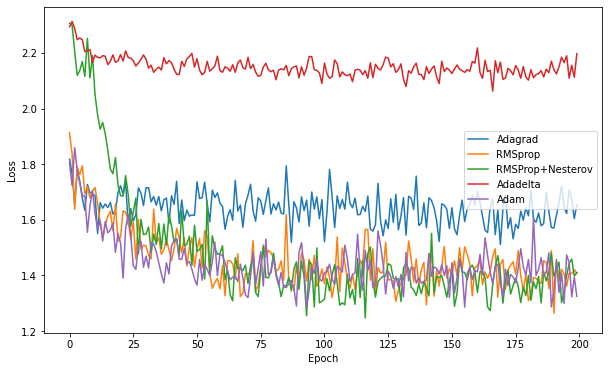

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for i, metric in enumerate(metrics):
    ax.plot(range(n_epochs), metric["losses"], label=metric["optimizer"])

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend(loc="best")
fig.show()

In [44]:
for i, metric in enumerate(metrics):
    print(f"{metric['optimizer']}: Final Loss: {metric['losses'][-1]}, Final Accuracy: {metric['accuracy']}")

Adagrad: Final Loss: 1.6543464660644531, Final Accuracy: 44
RMSprop: Final Loss: 1.4078364372253418, Final Accuracy: 50
RMSProp+Nesterov: Final Loss: 1.4095723628997803, Final Accuracy: 52
Adadelta: Final Loss: 2.1971960067749023, Final Accuracy: 26
Adam: Final Loss: 1.3246097564697266, Final Accuracy: 50


**Training Loss Comparison**

In general, the training loss increased using dropout. However, the `RMSProp` and `RMSProp+Nesterov` optimizers performed the best.

|                  | Without Dropout    | With Dropout       | Difference (with - without) |
|------------------|--------------------|--------------------|-----------------------------|
| Adagrad          | 1.4563932418823242 | 1.6543464660644531 | 0.1979532241821289          |
| RMSprop          | 1.0217969417572021 | 1.4078364372253418 | 0.3860394954681397          |
| RMSProp+Nesterov | 0.9130889177322388 | 1.4095723628997803 | 0.4964834451675415          |
| Adadelta         | 2.0367579460144043 | 2.1971960067749023 | 0.160438060760498           |
| Adam             | 0.948557436466217  | 1.3246097564697266 | 0.3760523200035096          |

**Test Accuracy Comparison**

Test accuracy seems to drop when dropout is applied.

|                  | Without Dropout | With Dropout | Difference (with - without) |
|------------------|-----------------|--------------|-----------------------------|
| Adagrad          | 48              | 44           | -4                          |
| RMSprop          | 55              | 50           | -5                          |
| RMSProp+Nesterov | 57              | 52           | -5                          |
| Adadelta         | 27              | 26           | -1                          |
| Adam             | 56              | 50           | -6                          |

## Data Parallelism in Pytorch
### Q2.1
#### Load Data

In [3]:
normalize = transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])

trainloader = torch.utils.data.DataLoader(
        torchvision.datasets.CIFAR10(root='./data', train=True, transform=transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, 4),
            transforms.ToTensor(),
            normalize,
        ]), download=True),
        batch_size=128, shuffle=True,
        num_workers=2, pin_memory=True)

valloader = torch.utils.data.DataLoader(
        torchvision.datasets.CIFAR10(root='./data', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ])),
        batch_size=100, shuffle=False,
        num_workers=2, pin_memory=True)

Files already downloaded and verified


#### Model

In [4]:
import torch.nn as nn

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [9]:
def train(train_loader, model, criterion, optimizer, device, epoch):
    """
        Run one train epoch
    """
    print_freq = 50
    l = len(train_loader)
    
    # switch to train mode
    model.train()
    
    runtime = 0
    for i, (inputs, target) in enumerate(train_loader):
        start = datetime.now()
        target = target.to(device)
        input_var = inputs.to(device)
        target_var = target

        # compute output
        output = model(input_var)
        loss = criterion(output, target_var)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        runtime += (datetime.now() - start).total_seconds()
        
        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'.format(epoch, i, l))
        
    return runtime

In [13]:
size = 32
train_times_g1 = []
n_epochs = 2

device = torch.device("cuda:0")
print(f"Using device: {device}")

try:
    while True:
        trainloader = torch.utils.data.DataLoader(
        torchvision.datasets.CIFAR10(root='./data', train=True, transform=transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, 4),
            transforms.ToTensor(),
            normalize,
        ]), download=True),
        batch_size=size, shuffle=True,
        num_workers=2, pin_memory=True)

        model = ResNet18()
        model = model.to(device)

        criterion = nn.CrossEntropyLoss().to(device)

        optimizer = torch.optim.SGD(model.parameters(), 0.1,
                                momentum=0.9,
                                weight_decay=5e-4)

        runtimes = []
        for epoch in range(n_epochs):
            print(f"Batch Size: {size}")
            runtimes.append(train(trainloader, model, criterion, optimizer, device))

        train_times_g1.append(runtimes[-1])
        
        size *= 4
except Exception as e:
    print(e)



Using device: cuda:0
Files already downloaded and verified
Batch Size: 32
Epoch: [0][0/1563]	
Epoch: [0][50/1563]	
Epoch: [0][100/1563]	
Epoch: [0][150/1563]	
Epoch: [0][200/1563]	
Epoch: [0][250/1563]	
Epoch: [0][300/1563]	
Epoch: [0][350/1563]	
Epoch: [0][400/1563]	
Epoch: [0][450/1563]	
Epoch: [0][500/1563]	
Epoch: [0][550/1563]	
Epoch: [0][600/1563]	
Epoch: [0][650/1563]	
Epoch: [0][700/1563]	
Epoch: [0][750/1563]	
Epoch: [0][800/1563]	
Epoch: [0][850/1563]	
Epoch: [0][900/1563]	
Epoch: [0][950/1563]	
Epoch: [0][1000/1563]	
Epoch: [0][1050/1563]	
Epoch: [0][1100/1563]	
Epoch: [0][1150/1563]	
Epoch: [0][1200/1563]	
Epoch: [0][1250/1563]	
Epoch: [0][1300/1563]	
Epoch: [0][1350/1563]	
Epoch: [0][1400/1563]	
Epoch: [0][1450/1563]	
Epoch: [0][1500/1563]	
Epoch: [0][1550/1563]	
Batch Size: 32
Epoch: [1][0/1563]	
Epoch: [1][50/1563]	
Epoch: [1][100/1563]	
Epoch: [1][150/1563]	
Epoch: [1][200/1563]	
Epoch: [1][250/1563]	
Epoch: [1][300/1563]	
Epoch: [1][350/1563]	
Epoch: [1][400/1563]	
Epo

#### Single GPU Training Time

In [14]:
print("Single GPU Compute Time")
print("Batch Size, Training Time(s)")
i = 0
while i < len(train_times_g1):
    print(f"{32*(4**i)}, {train_times_g1[i]:.3f}")
    i += 1

Single GPU Compute Time
Batch Size, Training Time(s)
32, 27.438
128, 17.857
512, 18.398
2048, 18.061


### Q2.2
#### 2 GPU performance

In [15]:
size=32
train_times_g2 = []
compute_times_g2 = []

device = torch.device("cuda")
print(f"Using device: {device}")

try:
    while True:
        start = datetime.now()
        trainloader = torch.utils.data.DataLoader(
        torchvision.datasets.CIFAR10(root='./data', train=True, transform=transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, 4),
            transforms.ToTensor(),
            normalize,
        ]), download=True),
        batch_size=size, shuffle=True,
        num_workers=2, pin_memory=True)

        model = ResNet18()
        model = torch.nn.DataParallel(model)
        model = model.to(device)

        criterion = nn.CrossEntropyLoss().to(device)

        optimizer = torch.optim.SGD(model.parameters(), 0.1,
                                momentum=0.9,
                                weight_decay=5e-4)

        train_time = (datetime.now() - start).total_seconds()

        runtimes = []
        for epoch in range(n_epochs):
            print(f"Batch Size: {size}")
            runtimes.append(train(trainloader, model, criterion, optimizer, device))

        train_time += runtimes[-1]
        train_times_g2.append(train_time)
        compute_times_g2.append(runtimes[-1])
        
        size *= 4
except Exception as e:
    print(e)


Using device: cuda
Files already downloaded and verified
Batch Size: 32
Epoch: [0][0/1563]	
Epoch: [0][50/1563]	
Epoch: [0][100/1563]	
Epoch: [0][150/1563]	
Epoch: [0][200/1563]	
Epoch: [0][250/1563]	
Epoch: [0][300/1563]	
Epoch: [0][350/1563]	
Epoch: [0][400/1563]	
Epoch: [0][450/1563]	
Epoch: [0][500/1563]	
Epoch: [0][550/1563]	
Epoch: [0][600/1563]	
Epoch: [0][650/1563]	
Epoch: [0][700/1563]	
Epoch: [0][750/1563]	
Epoch: [0][800/1563]	
Epoch: [0][850/1563]	
Epoch: [0][900/1563]	
Epoch: [0][950/1563]	
Epoch: [0][1000/1563]	
Epoch: [0][1050/1563]	
Epoch: [0][1100/1563]	
Epoch: [0][1150/1563]	
Epoch: [0][1200/1563]	
Epoch: [0][1250/1563]	
Epoch: [0][1300/1563]	
Epoch: [0][1350/1563]	
Epoch: [0][1400/1563]	
Epoch: [0][1450/1563]	
Epoch: [0][1500/1563]	
Epoch: [0][1550/1563]	
Batch Size: 32
Epoch: [1][0/1563]	
Epoch: [1][50/1563]	
Epoch: [1][100/1563]	
Epoch: [1][150/1563]	
Epoch: [1][200/1563]	
Epoch: [1][250/1563]	
Epoch: [1][300/1563]	
Epoch: [1][350/1563]	
Epoch: [1][400/1563]	
Epoch

#### 2 GPU Training Time

In [16]:
print("2 GPU Training Time (with Data Load)")
print("Batch Size, Training Time(s)")
i = 0
while i < len(train_times_g2):
    print(f"{32*(4**i)}, {train_times_g2[i]:.3f}")
    i += 1

2 GPU Training Time (with Data Load)
Batch Size, Training Time(s)
32, 50.353
128, 20.399
512, 13.410
2048, 6.652
8192, 6.543


#### 2 GPU Speedup
| Batch Size | Speedup |
|------------|---------|
| 32         | 1.09    |
| 128        | 1.75    |
| 512        | 2.744   |

#### 4 GPU Performance

In [14]:
size=32
train_times_g4 = []
compute_times_g4 = []
n_epochs = 2

device = torch.device("cuda")
print(f"Using device: {device}")

try:
    while True:
        start = datetime.now()
        trainloader = torch.utils.data.DataLoader(
        torchvision.datasets.CIFAR10(root='./data', train=True, transform=transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, 4),
            transforms.ToTensor(),
            normalize,
        ]), download=True),
        batch_size=size, shuffle=True,
        num_workers=2, pin_memory=True)

        model = ResNet18()
        model = torch.nn.DataParallel(model)
        model = model.to(device)

        criterion = nn.CrossEntropyLoss().to(device)

        optimizer = torch.optim.SGD(model.parameters(), 0.1,
                                momentum=0.9,
                                weight_decay=5e-4)

        train_time = (datetime.now() - start).total_seconds()

        runtimes = []
        for epoch in range(n_epochs):
            print(f"Batch Size: {size}")
            runtimes.append(train(trainloader, model, criterion, optimizer, device, epoch))

        train_time += runtimes[-1]
        train_times_g4.append(train_time)
        compute_times_g4.append(runtimes[-1])
        
        size *= 4
except Exception as e:
    print(e)


Using device: cuda
Files already downloaded and verified
Batch Size: 32
Epoch: [0][0/1563]	
Epoch: [0][50/1563]	
Epoch: [0][100/1563]	
Epoch: [0][150/1563]	
Epoch: [0][200/1563]	
Epoch: [0][250/1563]	
Epoch: [0][300/1563]	
Epoch: [0][350/1563]	
Epoch: [0][400/1563]	
Epoch: [0][450/1563]	
Epoch: [0][500/1563]	
Epoch: [0][550/1563]	
Epoch: [0][600/1563]	
Epoch: [0][650/1563]	
Epoch: [0][700/1563]	
Epoch: [0][750/1563]	
Epoch: [0][800/1563]	
Epoch: [0][850/1563]	
Epoch: [0][900/1563]	
Epoch: [0][950/1563]	
Epoch: [0][1000/1563]	
Epoch: [0][1050/1563]	
Epoch: [0][1100/1563]	
Epoch: [0][1150/1563]	
Epoch: [0][1200/1563]	
Epoch: [0][1250/1563]	
Epoch: [0][1300/1563]	
Epoch: [0][1350/1563]	
Epoch: [0][1400/1563]	
Epoch: [0][1450/1563]	
Epoch: [0][1500/1563]	
Epoch: [0][1550/1563]	
Batch Size: 32
Epoch: [1][0/1563]	
Epoch: [1][50/1563]	
Epoch: [1][100/1563]	
Epoch: [1][150/1563]	
Epoch: [1][200/1563]	
Epoch: [1][250/1563]	
Epoch: [1][300/1563]	
Epoch: [1][350/1563]	
Epoch: [1][400/1563]	
Epoch

In [15]:
print("4 GPU Training Time (with Data Load)")
print("Batch Size, Training Time(s)")
i = 0
while i < len(train_times_g4):
    print(f"{32*(4**i)}, {train_times_g4[i]:.3f}")
    i += 1

4 GPU Training Time (with Data Load)
Batch Size, Training Time(s)
32, 59.304
128, 17.801
512, 6.393
2048, 4.357
8192, 4.608


#### 4 GPU Speedup
| Batch Size | Speedup |
|------------|---------|
| 32         | 1.85    |
| 128        | 4.035   |
| 512        | 11.511  |

### Q2.3
The compute time for an `n`-GPU setup is defined as `T(1)/n` as each GPU instance will effectively compute over `1/n` amount of data as opposed to a single GPU.

The communication time is then defined as `<n-GPU Training time> - <n-GPU Compute time>`.

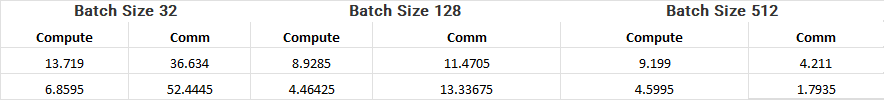

## Convolutional Neural Networks Architectures
### Q3.1

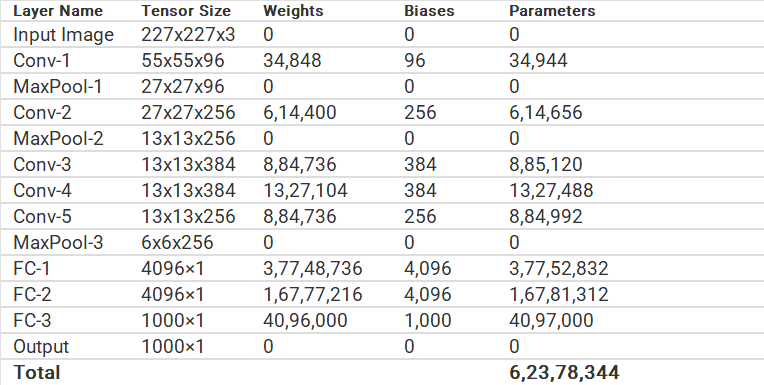

### Q3.2

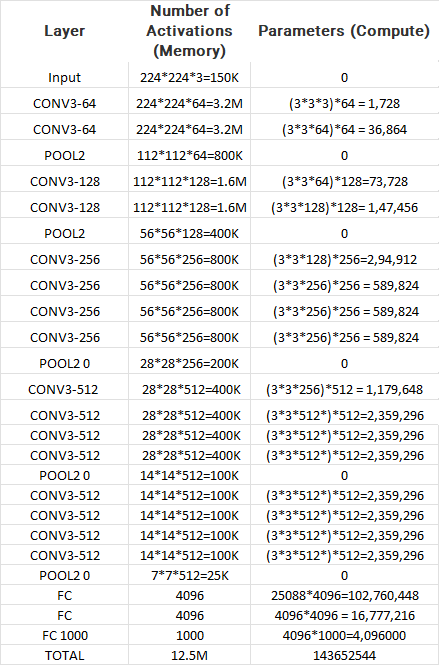

### Q3.4.a
The motivation for desigining Googlenet stems from the fact that while the simplest way to improve a deep neural network is to add more depth and width to the network, but it cannot be done without the extra overhead of computation and the higher chance of overfitting. In order to tackle these issues, we can move from fully connected to sparsely connected architectures, even inside the convolutions. The intuition then derives from the works of Arora et al, where it's stated that the probability distribution of the data-set is representable by a large, very sparse deep neural network, then the optimal network topology can be constructed layer by layer by analyzing the correlation statistics of the activations of the last layer and clustering neurons with highly correlated outputs.

The problem with this approach is that most modern computing infrastructures are particularly inefficient when it comes to numerical calculation on non-uniform sparse data structures. The authors solve this problem in Googlenet.

### Q3.4.b
#### Naive Inception
Filter Concatenation Size = (32*32*128)+(30*30*192)+(28*28*96)+(32*32*256) = 2,62,144

#### Dimensionality Reduction Inception
Filter Concatenation Size = (32*32*128)+(30*30*192)+(28*28*96)+(32*32*64) = 65,536

### Q3.4.c
#### Naive Inception
Num. Convolution Computations = (32*32*256*128)+(30*30*256*192)+(28*28*256*96) = 1,92,67,584

#### Dimensionality Reduction Inception
Num. Convolution Computations = (32*32*256*128)+(32*32*256*128)+(32*32*256*32)+(30*30*128*192)+(28*28*32*96)+(32*32*256*64) = 1,67,77,216

### Q3.4.d
One of the major problems with the Naive Inception approach is that even a modest number of 5×5 convolutions can be prohibitively expensive on top of a convolutional layer with a large number of filters. This problem becomes even more pronounced once pooling units are added to the mix, their number of output filters equals to the number of filters in the previous stage. The merging of the output of the pooling layer with the outputs of convolutional layers would lead to an inevitable increase in the number of outputs from stage to stage. Even while this architecture might cover the optimal sparse structure, it would do it very inefficiently, leading to a computational blow up within a few stages.

As observed above, Dimensionality reduction greatly helps in reducing computational cost of the Inception block. One of the main beneficial aspects of this architecture is that it allows for increasing the number of units at each stage significantly without an uncontrolled blow-up in computational complexity. The ubiquitous use of dimension reduction allows for shielding the large number of input filters of the last stage to the next layer, first reducing their dimension before convolving over them with a large patch size.

In this case, we observe effectively a reduction in the computational cost by 24,90,368.

### Q3.5.a
In Fast R-CNN, we feed the input image to the CNN to generate a convolutional feature map. From the convolutional feature map, we identify the region of proposals and warp them into squares and by using a RoI pooling layer we reshape them into a fixed size so that it can be fed into a fully connected layer. From the RoI feature vector, we use a softmax layer to predict the class of the proposed region and also the offset values for the bounding box. The network then **uses selective search to find out the region proposals.**

In Faster R-CNN, the image is provided as an input to a convolutional network which provides a convolutional feature map. **Instead of using selective search algorithm on the feature map to identify the region proposals, a separate network is used to predict the region proposals.** The predicted region proposals are then reshaped using a RoI pooling layer which is then used to classify the image within the proposed region and predict the offset values for the bounding boxes.

### 3.5.b
A Region Proposal Network (RPN) takes an image (of any size) as input and outputs a set of rectangular object proposals, each with an objectness score.

To generate region proposals, we slide a small network over the convolutional feature map output by the last shared convolutional layer. This small network takes as input an n × n spatial window of the input convolutional feature map. Each sliding window is mapped to a lower-dimensional feature (256-d for ZF and 512-d for VGG, with ReLU following). This feature is fed into two sibling fully-connected layers, a box-regression layer (reg) and a box-classification layer.

### Q3.5.c
#### Anchor
According to the next figure, the feature map of the last shared convolution layer is passed through a rectangular sliding window of size nxn, where n=3 for the VGG-16 net. For each window, K region proposals are generated. Each proposal is parametrized according to a reference box which is called an anchor box. The 2 parameters of the anchor boxes are:

1. Scale
2. Aspect Ratio

Generally, there are 3 scales and 3 aspect ratios and thus there is a total of K=9 anchor boxes. But K may be different than 9. In other words, K regions are produced from each region proposal, where each of the K regions varies in either the scale or the aspect ratio.  Some of the anchor variations are shown in the next figure.

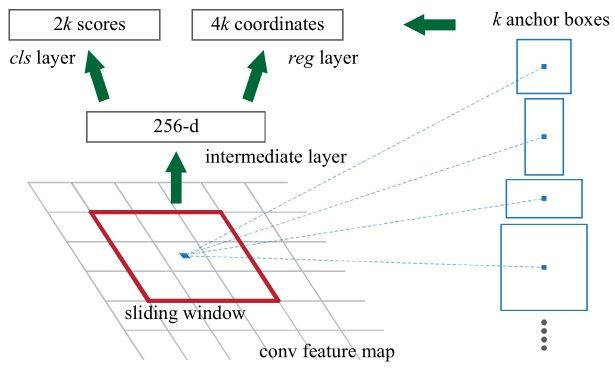

Using reference anchors (i.e. anchor boxes), a single image at a single scale is used while being able to offer scale-invariant object detectors, as the anchors exist at different scales. This avoids using multiple images or filters. The multi-scale anchors are key to share features across the RPN and the Fast R-CNN detection network.

For each nxn region proposal, a feature vector (of length 256 for ZF net and 512 for the VGG-16 net) is extracted. This vector is then fed to 2 sibling fully-connected layers:

- The first FC layer is named `cls`, and represents a binary classifier that generates the objectness score for each region proposal (i.e. whether the region contains an object, or is part of the background).
- The second FC layer is named `reg` which returns a 4-D vector defining the bounding box of the region.

The first FC layer (i.e. binary classifier) has 2 outputs. The first is for classifying the region as a background, and the second is for classifying the region as an object. The next section discusses how the objectness score is assigned to each anchor and how it is used to produce the classification label.

Objectness Score
The cls layer outputs a vector of 2 elements for each region proposal. If the first element is 1 and the second element is 0, then the region proposal is classified as background. If the second element is 1 and the first element is 0, then the region represents an object.

For training the RPN, each anchor is given a positive or negative objectness score based on the Intersection-over-Union (IoU).

The IoU is the ratio between the area of intersection between the anchor box and the ground-truth box to the area of union of the 2 boxes. The IoU ranges from 0.0 to 1.0. When there is no intersection, the IoU is 0.0. As the 2 boxes get closer to each other, the IoU increases until reaching 1.0 (when the 2 boxes are 100% identical).

The next 4 conditions use the IoU to determine whether a positive or a negative objectness score is assigned to an anchor:

- An anchor that has an IoU overlap higher than 0.7 with any ground-truth box is given a positive objectness label.
- If there is no anchor with an IoU overlap higher than 0.7, then assign a positive label to the anchor(s) with the highest IoU overlap with a ground-truth box.
- A negative objectness score is assigned to a non-positive anchor when the IoU overlap for all ground-truth boxes is less than 0.3. A negative objectness score means the anchor is classified as background.
- Anchors that are neither positive nor negative do not contribute to the training objective.

### Q3.5.d
Some RPN proposals highly overlap with each other. To reduce redundancy, RPN's adopt non-maximum suppression (NMS) on the proposal regions based on their cls scores. In Faster R-CNN, we fix the IoU threshold for NMS at 0.7, which leaves us about 2000 proposal regions per image.

## Batch Augmentation, Cutout Regularization 
### Q4.1
**Cutout** is a regularization technique for convolutional neural networks where we essentially generate more training samples by creating versions of existing training input samples by removing a **contiguous sections**, thereby improving the generalization of the model by forcing it to focus more on generic minor features rather than local and specific major features of an image.

#### Advantages of Cutout over Simple Dropout
Cutout improves upon simple dropout due to the fact that the image is *augmented* (random section is removed) at the input stage and the subsequent feature maps in the deeper layers **also** do not contain the removed section. By contrast, simple dropout randomly removes features from every layer, creating the possibility of features removed in one layer to be present in another layer, thereby creating noisy representations of the input image. This *noise* **isn't generated** with cutout as the removed features remain consistent throughout the network, thereby creating a better (noise-free) augmented representation of training data.

In [2]:
# Utils
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = transF.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        
class Cutout(object):
    """
    Randomly mask out one or more patches from an image.
    taken from https://github.com/uoguelph-mlrg/Cutout
    Args:
        holes (int): Number of patches to cut out of each image.
        length (int): The length (in pixels) of each square patch.
    """

    def __init__(self, holes, length):
        self.holes = holes
        self.length = length

    def __call__(self, img):
        """
        Args:
            img (Tensor): Tensor image of size (C, H, W).
        Returns:
            Tensor: Image with holes of dimension length x length cut out of it.
        """
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img

In [3]:
batch_size = 4

transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


#### Original Image vs After Random Cutout

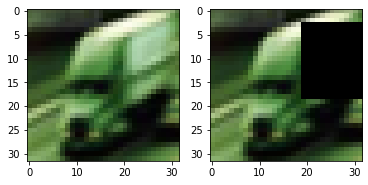

In [4]:
images, _ = next(iter(trainloader))
img = Cutout(1, 16)(images[0])

fig, axes = plt.subplots(ncols=2)
axes[0].imshow(images[0].permute(1, 2, 0))
axes[1].imshow(img.permute(1, 2, 0))

### Model

In [5]:
import torch.nn as nn
import torch.nn.init as init
# We define all the classes and function regarding the ResNet architecture in this code cell
__all__ = ["resnet20", "resnet32", "resnet44", "resnet56", "resnet110", "resnet1202"]
 
def _weights_init(m):
    """
        Initialization of CNN weights
    """
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)


class LambdaLayer(nn.Module):
    """
      Identity mapping between ResNet blocks with diffrenet size feature map
    """
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)

# A basic block as shown in Fig.3 (right) in the paper consists of two convolutional blocks, each followed by a Bach-Norm layer. 
# Every basic block is shortcuted in ResNet architecture to construct f(x)+x module. 
# Expansion for option 'A' in the paper is equal to identity with extra zero entries padded
# for increasing dimensions between layers with different feature map size. This option introduces no extra parameter. 
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 experiment, ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# Stack of 3 times 2*n (n is the number of basic blocks) layers are used for making the ResNet model, 
# where each 2n layers have feature maps of size {16,32,64}, respectively. 
# The subsampling is performed by convolutions with a stride of 2.
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)
        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def resnet20():
    return ResNet(BasicBlock, [3, 3, 3])


def resnet32():
    return ResNet(BasicBlock, [5, 5, 5])


def resnet44():
    return ResNet(BasicBlock, [7, 7, 7])


def resnet56():
    return ResNet(BasicBlock, [9, 9, 9])


def resnet110():
    return ResNet(BasicBlock, [18, 18, 18])


def resnet1202():
    return ResNet(BasicBlock, [200, 200, 200])


def test(net):
    total_params = 0

    for x in filter(lambda p: p.requires_grad, net.parameters()):
        total_params += np.prod(x.data.numpy().shape)
    print("Total number of params", total_params)
    print("Total layers", len(list(filter(lambda p: p.requires_grad and len(p.data.size())>1, net.parameters()))))


if __name__ == "__main__":
    for net_name in __all__:
        if net_name.startswith('resnet'):
            print(net_name)
            test(globals()[net_name]())
            print()

resnet20
Total number of params 269722
Total layers 20

resnet32
Total number of params 464154
Total layers 32

resnet44
Total number of params 658586
Total layers 44

resnet56
Total number of params 853018
Total layers 56

resnet110
Total number of params 1727962
Total layers 110

resnet1202
Total number of params 19421274
Total layers 1202



### Hyperparameter Class

In [6]:
class MyResNetArgs:
   """
    Passing the hyperparameters to the model
   """
   def __init__(self, arch='resnet20' ,epochs=200, start_epoch=0, batch_size=128, lr=0.1, momentum=0.9, weight_decay=1e-4, print_freq=55,
                 evaluate=0, pretrained=0, half=0, save_dir='save_temp', save_every=10):
        self.save_every = save_every #Saves checkpoints at every specified number of epochs
        self.save_dir = save_dir #The directory used to save the trained models
        self.half = half #use half-precision(16-bit)
        self.evaluate = evaluate #evaluate model on the validation set
        self.pretrained = pretrained #evaluate the pretrained model on the validation set
        self.print_freq = print_freq #print frequency 
        self.weight_decay = weight_decay
        self.momentum = momentum 
        self.lr = lr #Learning rate
        self.batch_size = batch_size 
        self.start_epoch = start_epoch
        self.epochs = epochs
        self.arch = arch #ResNet model

### Initialization

In [7]:
from torchsummary import summary
args=MyResNetArgs('resnet44',pretrained=0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
model = resnet44().to(device)
summary(model, (3,32,32))
best_prec1 = 0

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
            Conv2d-3           [-1, 16, 32, 32]           2,304
       BatchNorm2d-4           [-1, 16, 32, 32]              32
            Conv2d-5           [-1, 16, 32, 32]           2,304
       BatchNorm2d-6           [-1, 16, 32, 32]              32
        BasicBlock-7           [-1, 16, 32, 32]               0
            Conv2d-8           [-1, 16, 32, 32]           2,304
       BatchNorm2d-9           [-1, 16, 32, 32]              32
           Conv2d-10           [-1, 16, 32, 32]           2,304
      BatchNorm2d-11           [-1, 16, 32, 32]              32
       BasicBlock-12           [-1, 16, 32, 32]               0
           Conv2d-13           [-1, 16, 32, 32]           2,304
      BatchNorm2d-14           [-1, 16,

### Training

In [8]:
import time

def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    """
    Save the training model
    """
    torch.save(state, filename)


def train(train_loader, model, criterion, optimizer, epoch, M=0):
    """
        Run one train epoch
    """
    print_freq = 50
    
    # switch to train mode
    model.train()

    end = time.time()
    losses = []
    for i, (inputs, target) in enumerate(train_loader):
        
        if M > 0:
            for _ in range(M):
                for j in range(inputs.shape[0]):
                    inputs[j] = Cutout(M, 16)(inputs[j])
                    
                target = target.cuda()
                input_var = inputs.cuda()

                # compute output
                output = model(input_var)
                loss = criterion(output, target)

                # compute gradient and do SGD step
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                output = output.float()
                loss = loss.item()
                losses.append(loss)
        
        else:
            target = target.cuda()
            input_var = inputs.cuda()
            # compute output
            output = model(input_var)
            loss = criterion(output, target)

            # compute gradient and do SGD step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            output = output.float()
            loss = loss.item()
            losses.append(loss)
            
        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time:.3f}\t'
                  'Loss {loss:.4f}\t'.format(
                      epoch, i, len(train_loader), batch_time=time.time() - end, loss=loss))
        
        # measure elapsed time
        end = time.time()
    
    return sum(losses) / len(losses)


def accuracy(val_loader, model, criterion):
    """
    Run evaluation
    """
    correct = 0
    total = 0
    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        for i, (inp, target) in enumerate(val_loader):
            target = target.cuda()
            input_var = inp.cuda()
            target_var = target.cuda()

            # compute output
            output = model(input_var)
            _, prediction = torch.max(output.data, 1)
            
            correct += (prediction == target).sum().item()
            total += target.size(0)

    return (100 * correct) // total

### Load Data

In [9]:
normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
batch_size = 128

trainloader = torch.utils.data.DataLoader(
        torchvision.datasets.CIFAR10(root='./data', train=True, transform=transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, 4),
            transforms.ToTensor(),
            normalize,
        ]), download=True),
        batch_size=batch_size, shuffle=True,
        num_workers=0, pin_memory=True)

valloader = torch.utils.data.DataLoader(
        torchvision.datasets.CIFAR10(root='./data', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ])),
        batch_size=128, shuffle=False,
        num_workers=0, pin_memory=True)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


### Q4.2

In [14]:
def training_validation_error(trainloader, valloader, epochs, accuracy_threshold = None, M=0):
    lr, momentum, weight_decay = 0.1, 0.9, 1e-4

    model = resnet44()
    model.cuda()


    # define loss function (criterion) and pptimizer
    criterion = nn.CrossEntropyLoss().cuda()

    optimizer = torch.optim.SGD(model.parameters(), lr,
                                momentum=momentum,
                                weight_decay=weight_decay)

    lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30, 60, 80])
    val_error = []
    epochs_elapsed, start_time = 0, datetime.now()

    for epoch in range(epochs):
        epochs_elapsed += 1
        # train for one epoch
        print('Training Resnet-44 model')
        print('current lr {:.5e}'.format(optimizer.param_groups[0]['lr']))
        train(trainloader, model, criterion, optimizer, epoch, M)
        lr_scheduler.step()

        # evaluate on validation set
        epoch_accuracy = accuracy(valloader, model, criterion)
        val_error.append(100. - epoch_accuracy)
        
        if accuracy_threshold is not None and epoch_accuracy >= accuracy_threshold:
            break
        
    return val_error, epochs_elapsed, datetime.now() - start_time

epochs = 100
base_error, _, _ = training_validation_error(trainloader, valloader, epochs)

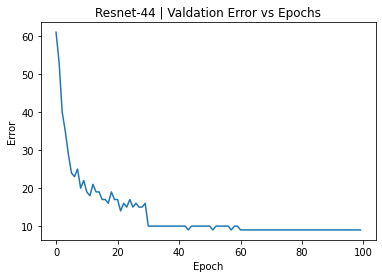

In [12]:
plt.plot(range(epochs), base_error)
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Resnet-44 | Valdation Error vs Epochs")
plt.show()

### Q4.3
#### Load Data with Cutout

In [22]:
from torch.utils.data import ConcatDataset

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
batch_size = 128
epochs = 100

n_holes = [2,4,8,16,32]
epochs_till_94, runtime_till_94 = [],  []
error_metrics = []

for holes in n_holes:
    # Base training set with no augmentations
    transform = transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.RandomCrop(32, 4),
                transforms.ToTensor(),
                normalize,
            ])
    
    trainloader = torch.utils.data.DataLoader(torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform),
            batch_size=batch_size, shuffle=True,
            num_workers=1, pin_memory=True)

    valloader = torch.utils.data.DataLoader(
            torchvision.datasets.CIFAR10(root='./data', train=False, transform=transforms.Compose([
                transforms.ToTensor(),
                normalize,
            ])),
            batch_size=batch_size, shuffle=False,
            num_workers=1, pin_memory=True)
    
    cutout_error, epochs_elapsed, runtime = training_validation_error(trainloader, valloader, epochs, accuracy_threshold = 94, M=holes)
    epochs_till_94.append(epochs_elapsed)
    runtime_till_94.append(runtime.total_seconds())
    error_metrics.append((epochs_elapsed, cutout_error))

Files already downloaded and verified
Training Resnet-44 model
current lr 1.00000e-01
Epoch: [0][0/391]	Time 0.258	Loss 4.7462	
Epoch: [0][50/391]	Time 0.127	Loss 2.3197	
Epoch: [0][100/391]	Time 0.119	Loss 2.0721	
Epoch: [0][150/391]	Time 0.127	Loss 1.9303	
Epoch: [0][200/391]	Time 0.127	Loss 1.9312	
Epoch: [0][250/391]	Time 0.122	Loss 1.8845	
Epoch: [0][300/391]	Time 0.127	Loss 1.8818	
Epoch: [0][350/391]	Time 0.128	Loss 1.9233	
Training Resnet-44 model
current lr 1.00000e-01
Epoch: [1][0/391]	Time 0.249	Loss 1.8539	
Epoch: [1][50/391]	Time 0.123	Loss 1.7323	
Epoch: [1][100/391]	Time 0.128	Loss 1.7158	
Epoch: [1][150/391]	Time 0.127	Loss 1.7035	
Epoch: [1][200/391]	Time 0.122	Loss 1.7137	
Epoch: [1][250/391]	Time 0.121	Loss 1.6172	
Epoch: [1][300/391]	Time 0.127	Loss 1.7542	
Epoch: [1][350/391]	Time 0.122	Loss 1.6876	
Training Resnet-44 model
current lr 1.00000e-01
Epoch: [2][0/391]	Time 0.252	Loss 1.7385	
Epoch: [2][50/391]	Time 0.129	Loss 1.7845	
Epoch: [2][100/391]	Time 0.134	Loss

Exception in thread Thread-795:
Traceback (most recent call last):
  File "/share/apps/python/3.8.6/intel/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/share/apps/python/3.8.6/intel/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/home/sj2810/.local/lib/python3.8/site-packages/torch/utils/data/_utils/pin_memory.py", line 28, in _pin_memory_loop
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/share/apps/python/3.8.6/intel/lib/python3.8/multiprocessing/queues.py", line 116, in get
    return _ForkingPickler.loads(res)
  File "/home/sj2810/.local/lib/python3.8/site-packages/torch/multiprocessing/reductions.py", line 289, in rebuild_storage_fd
    fd = df.detach()
  File "/share/apps/python/3.8.6/intel/lib/python3.8/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/share/apps/python/3.8.6/intel/lib/python3.8/mult

KeyboardInterrupt: 

#### 10 Epoch Run

In [64]:
class PDF(object):
  def __init__(self, pdf, size=(200,200)):
    self.pdf = pdf
    self.size = size

  def _repr_html_(self):
    return '<iframe src={0} width={1[0]} height={1[1]}></iframe>'.format(self.pdf, self.size)

  def _repr_latex_(self):
    return r'\includegraphics[width=1.0\textwidth]{{{0}}}'.format(self.pdf)

PDF('q4_e10.pdf',size=(900,900))

Text(0, 0.5, 'Time(hrs)')

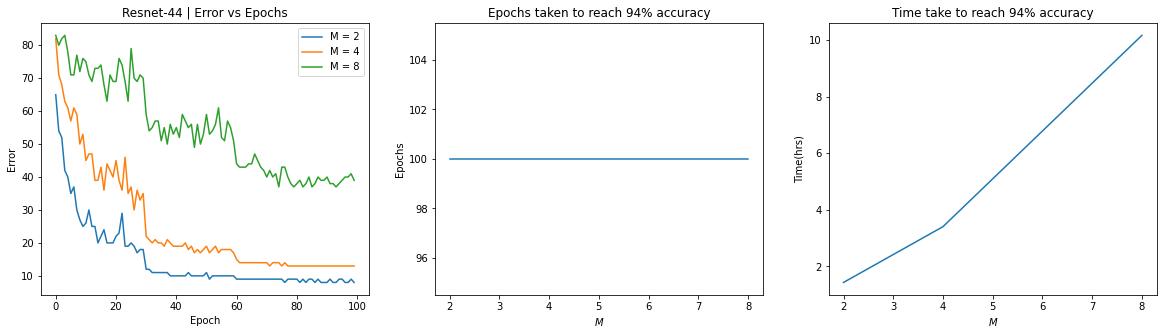

In [30]:
# Plot graphs
fig, axes = plt.subplots(ncols=3, figsize=(20, 5))

for i, actual_epochs, error in[(i, x[0], x[1]) for i, x in enumerate(error_metrics)]:
    axes[0].plot(range(actual_epochs), error, label=f"M = {n_holes[i]}")

axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Error")
axes[0].set_title("Resnet-44 | Error vs Epochs")
axes[0].legend(loc="best")

axes[1].plot(n_holes[:3], epochs_till_94)
axes[1].set_xlabel(r"$M$")
axes[1].set_ylabel("Epochs")
axes[1].set_title("Epochs taken to reach 94% accuracy")

axes[2].set_title("Time take to reach 94% accuracy")
axes[2].plot(n_holes[:3], [x / 3600 for x in runtime_till_94])
axes[2].set_xlabel(r"$M$")
axes[2].set_ylabel("Time(hrs)")

In [29]:
sum(runtime_till_94) / 3600

14.997615586944445

In [16]:
from utils.notification.emailer import *

msg = message.email(text="Training Done.", subject="IDLS Lab Notebook Notification")
mail_io.send(msg, server="smtp.gmail.com")